<a href="https://colab.research.google.com/github/Edna-cyber/telepresence/blob/3d/3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from PIL import Image
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt

In [21]:
# code for installing pytorch3d inside Google Colab
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt221/download.html


In [22]:
import pytorch3d
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
)
from pytorch3d.structures import Pointclouds

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
image = Image.open("/content/drive/MyDrive/Gaussian/panda.png")
image_np = np.array(image)
image_normalized = image_np.astype(np.float32) / 255.0

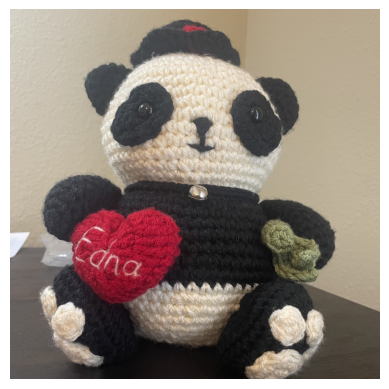

In [25]:
plt.imshow(image_normalized)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [26]:
f = 3000 # focal length in pixels, calculated from iphone data # modified
image_resolution = (3024, 3024)

In [27]:
def uv_to_xyz(u, v, d):
    """
    Convert 2D image coordinates (u, v) to 3D world coordinates (x, y, z).

    Parameters:
    - u, v: The 2D image coordinates.
    - f: The focal length of the camera in pixels.
    - d: The depth from the camera to the physical object.
    - principal_point: A tuple (u_0, v_0) representing the principal point of the camera (usually the image center).

    Returns:
    - A tuple (x, y, z) representing the 3D world coordinates.
    """
    w, h = image_resolution
    u_0, v_0 = w/2, h/2
    z = 1 / d
    x = (u_0-u)*z/f # flip the sign because pytorch3d x points left, y points up
    y = (v_0-v)*z/f
    return (x,y,z)

In [28]:
# Example usage
u, v = 700, 400 # example 2D image coordinates
d = 1
x, y, z = uv_to_xyz(u, v, d)
print(f"3D coordinates: x={x}, y={y}, z={z}")

3D coordinates: x=0.27066666666666667, y=0.37066666666666664, z=1.0


In [29]:
def twod_to_threed_lifting(f,d):
    w, h = image_resolution
    u_grid, v_grid = np.meshgrid(np.arange(w), np.arange(h))
    vectorized_func = np.vectorize(uv_to_xyz)
    x, y, z = vectorized_func(u_grid, v_grid, d)
    threed_coordinates = np.stack((x, y, z), axis=-1)
    print(threed_coordinates.shape)
    print(threed_coordinates)
    return np.stack((x, y, z), axis=-1)

In [30]:
far_threed_coord = twod_to_threed_lifting(f,1)

(3024, 3024, 3)
[[[ 0.504       0.504       1.        ]
  [ 0.50366667  0.504       1.        ]
  [ 0.50333333  0.504       1.        ]
  ...
  [-0.503       0.504       1.        ]
  [-0.50333333  0.504       1.        ]
  [-0.50366667  0.504       1.        ]]

 [[ 0.504       0.50366667  1.        ]
  [ 0.50366667  0.50366667  1.        ]
  [ 0.50333333  0.50366667  1.        ]
  ...
  [-0.503       0.50366667  1.        ]
  [-0.50333333  0.50366667  1.        ]
  [-0.50366667  0.50366667  1.        ]]

 [[ 0.504       0.50333333  1.        ]
  [ 0.50366667  0.50333333  1.        ]
  [ 0.50333333  0.50333333  1.        ]
  ...
  [-0.503       0.50333333  1.        ]
  [-0.50333333  0.50333333  1.        ]
  [-0.50366667  0.50333333  1.        ]]

 ...

 [[ 0.504      -0.503       1.        ]
  [ 0.50366667 -0.503       1.        ]
  [ 0.50333333 -0.503       1.        ]
  ...
  [-0.503      -0.503       1.        ]
  [-0.50333333 -0.503       1.        ]
  [-0.50366667 -0.503       

In [31]:
close_threed_coord = twod_to_threed_lifting(f,0.5)

(3024, 3024, 3)
[[[ 1.008       1.008       2.        ]
  [ 1.00733333  1.008       2.        ]
  [ 1.00666667  1.008       2.        ]
  ...
  [-1.006       1.008       2.        ]
  [-1.00666667  1.008       2.        ]
  [-1.00733333  1.008       2.        ]]

 [[ 1.008       1.00733333  2.        ]
  [ 1.00733333  1.00733333  2.        ]
  [ 1.00666667  1.00733333  2.        ]
  ...
  [-1.006       1.00733333  2.        ]
  [-1.00666667  1.00733333  2.        ]
  [-1.00733333  1.00733333  2.        ]]

 [[ 1.008       1.00666667  2.        ]
  [ 1.00733333  1.00666667  2.        ]
  [ 1.00666667  1.00666667  2.        ]
  ...
  [-1.006       1.00666667  2.        ]
  [-1.00666667  1.00666667  2.        ]
  [-1.00733333  1.00666667  2.        ]]

 ...

 [[ 1.008      -1.006       2.        ]
  [ 1.00733333 -1.006       2.        ]
  [ 1.00666667 -1.006       2.        ]
  ...
  [-1.006      -1.006       2.        ]
  [-1.00666667 -1.006       2.        ]
  [-1.00733333 -1.006       

In [32]:
# x,y,z,r,g,b
far_lifted_coord = np.concatenate((far_threed_coord, image_normalized), axis=2)
far_lifted_coord.shape

(3024, 3024, 6)

In [33]:
close_lifted_coord = np.concatenate((close_threed_coord, image_normalized), axis=2)

In [34]:
def render(points, colors):
    points = torch.tensor(points, dtype=torch.float32)
    points = points.view(-1, points.size(-1)).to(device)

    # Create a point cloud structure
    colors = torch.tensor(colors, dtype=torch.float32)
    colors = colors.view(-1, colors.size(-1)).to(device)

    # Create the Pointclouds object with points and their associated colors
    cloud = Pointclouds(points=[points], features=[colors])

    R, T = look_at_view_transform(2.7, 0, 180)  # camera distance, elevation, azimuth
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Rasterization settings for rendering the point cloud, can adjust the size of the points, etc.
    raster_settings = PointsRasterizationSettings(
        image_size=512,
        radius = 0.003,
        points_per_pixel = 10
    )

    # Point renderer for rendering the point cloud
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
        compositor=AlphaCompositor()
    )

    images = renderer(cloud)
    image_np = images[0, ..., :3].cpu().numpy()  # discard the alpha channel
    plt.imshow(image_np)
    plt.show()

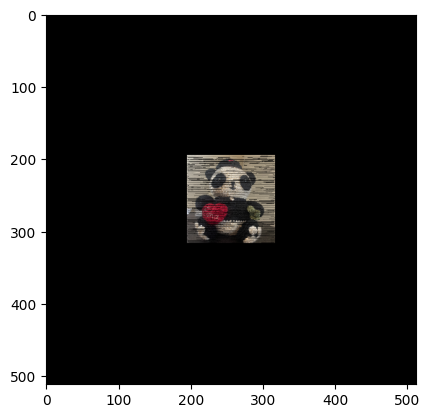

In [35]:
far_gt = render(far_threed_coord, image_normalized)

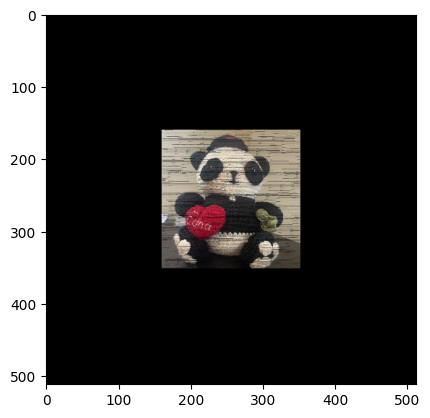

In [36]:
close_gt = render(close_threed_coord, image_normalized)